### Transfer Learning: Fine-Tuning

In fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data. For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-**3+ layers** of a pre-trained model.

Additional Topics: 
* **ModelCheckpoint** callback to save intermediate training results
* Comparing model experiments results using **TensorBoard**

Dataset: Food

![](https://camo.githubusercontent.com/a30cd9d1a1f7b27a2d429dddb2a436ba4e6fd12df16b6623f3385cac6fba333b/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30352d7472616e736665722d6c6561726e696e672d666561747572652d65787472616374696f6e2d76732d66696e652d74756e696e672e706e67)

In [1]:
# Get GPU info
# 'nvidia-smi

In [2]:
import os
import numpy as np
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Getting custom python packages from GitHub URL

In [3]:
# Get helper_functions.py script from course GitHub
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [4]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [5]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [6]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [7]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [8]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [9]:
import zipfile

# Unzip the downloaded file
def unzip_data(zip_file_name):
  zip_ref = zipfile.ZipFile(zip_file_name, "r")
  zip_ref.extractall()
  zip_ref.close()

In [10]:
import os

def walk_through_dir(data_dir):
  for dirpath, dirnames, filenames in os.walk(data_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

Get 10% of the data of the 10 food classes

In [11]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

--2023-05-07 05:49:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   141MB/s    in 1.1s    

2023-05-07 05:49:24 (141 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



### Unzip the downloaded file

In [12]:
# Unzip the downloaded file
unzip_data("10_food_classes_10_percent.zip")

In [13]:
# Walk through pizza_steak directory and list number of files
walk_through_dir("/content/10_food_classes_10_percent")

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_cl

In [14]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

 ### tf.keras.prepreprocessing.image_dataset_from_directory()

One of the main benefits of using tf.keras.prepreprocessing.**image_dataset_from_directory**() rather than **ImageDataGenerator** is that it creates a **tf.data.Dataset** object rather than a generator. The main advantage of this is the tf.data.Dataset API is much **more efficient** (faster) than the ImageDataGenerator API which is paramount for larger datasets.

In [15]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create Training data Input
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE    # batch_size is 32 by default
    # batch_size - the batch size of the images we're going to load in. 
    # For example if the batch_size is 32 (the default), batches of 32 images 
    # and labels at a time will be passed to the model
)

# Create Testing data Input
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [16]:
# Check the training data datatype
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

(None, 224, 224, 3) => (Batch_size, Height, Width, Channels)

(None, 10) => (Batch_size, number of possible labels)

Both image tensors and labels are of the datatype **tf.float32**

In [17]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

See an example batch of data

In [18]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[5.83010216e+01 5.99438782e+01 4.00153046e+01]
   [2.17908096e+01 2.44591751e+01 1.17704029e+01]
   [9.89285851e+00 1.38112259e+01 4.61734819e+00]
   ...
   [5.95715370e+01 6.20000648e+01 3.93572731e+01]
   [3.94794426e+01 3.64029007e+01 1.94284153e+01]
   [3.37143898e+01 2.57143898e+01 1.27143908e+01]]

  [[4.21683655e+01 4.50969391e+01 2.83112240e+01]
   [4.27040625e+00 6.20407963e+00 1.98979557e-01]
   [1.00714293e+01 9.82653141e+00 7.95918882e-01]
   ...
   [6.11021461e+01 6.07143288e+01 3.90715370e+01]
   [3.84335556e+01 3.22855835e+01 1.62906857e+01]
   [3.35919724e+01 2.47857838e+01 1.21888781e+01]]

  [[1.75969391e+01 2.01581650e+01 6.66326618e+00]
   [9.17857361e+00 9.32143021e+00 5.96939325e-01]
   [1.31173458e+01 6.37755013e+00 1.90816319e+00]
   ...
   [6.43112717e+01 6.25714722e+01 4.10970306e+01]
   [3.95968666e+01 3.08264198e+01 1.56835766e+01]
   [3.88572121e+01 2.72857838e+01 1.52857838e+01]]

  ...

  [[1.64285719e+00 1.64285719e+00 0.00000000e+00]
   [4

Labels come out as one-hot encodings

### Model 0: Building a transfer learning model using the Keras Functional API

* Set the base model's trainable attribute to False to freeze all of the weights in the pre-trained model.

* Normalize the inputs to our model if it requires. Some models such as ResNetV250 require their inputs to be between 0 - 1.

* Pool the outputs of the base model into a shape compatible with the **output activation layer** (turn base model output tensors into same shape as label tensors). This can be done using **tf.keras.layers.GlobalAveragePooling2D()** or **tf.keras.layers.GlobalMaxPooling2D()** though the former is more common in practice.

* Create an output activation layer using tf.keras.layers.Dense() with the appropriate activation function and number of neurons. 

#### Create Base Model and Freeze

In [19]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [20]:
IMG_SHAPE = (224, 224, 3)

# Create inputs into the base model
inputs = tf.keras.layers.Input(shape=IMG_SHAPE, name='input_layer')

# If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

In [21]:
x = base_model(inputs)   # For EfficientNet, inputs don't have to be normalized

In [22]:
x.shape     # Data shape after passing it to base_model

TensorShape([None, 7, 7, 1280])

In [23]:
# Average Pooling the outputs of the base model 
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
x.shape

TensorShape([None, 1280])

In [24]:
# Create Output layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

In [25]:
EPOCHS = 5

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

# Fit the model
history_model_0 = model_0.fit(train_data_10_percent, epochs= EPOCHS, 
                              steps_per_epoch=len(train_data_10_percent), 
                              validation_data=test_data_10_percent,
                              # Go through less of the validation data so epochs are faster
                              validation_steps=int(0.25*len(test_data_10_percent)),
                              callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")]
                            )

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20230507-054940


Epoch 1/5
24/24 [==============================] - 29s 353ms/step - loss: 1.9130 - accuracy: 0.3787 - val_loss: 1.3060 - val_accuracy: 0.7270
Epoch 2/5
24/24 [==============================] - 5s 176ms/step - loss: 1.1090 - accuracy: 0.7653 - val_loss: 0.8795 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - 4s 135ms/step - loss: 0.8050 - accuracy: 0.8240 - val_loss: 0.7195 - val_accuracy: 0.8339
Epoch 4/5
24/24 [==============================] - 4s 140ms/step - loss: 0.6461 - accuracy: 0.8467 - val_loss: 0.6234 - val_accuracy: 0.8421
Epoch 5/5
24/24 [==============================] - 5s 174ms/step - loss: 0.5538 - accuracy: 0.8800 - val_loss: 0.5451 - val_accuracy: 0.8569


We passed our custom data to an already pre-trained model (EfficientNetB0), asked it "what patterns do you see?" and then put our own output layer on top to make sure the outputs were tailored to our desired number of classes.

In [26]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [27]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [28]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Input layer (None, 224, 224, 3) was transformed to be (None, 10) by the output layer where None is the placeholder for the batch size.

The only trainable parameters in the model are those in the output layer.

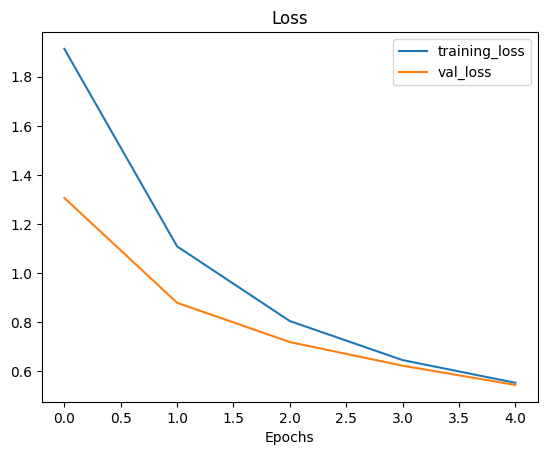

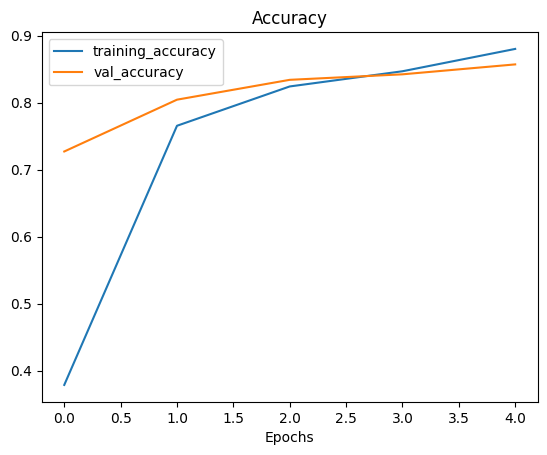

In [29]:
plot_loss_curves(history_model_0)

### Getting a feature vector from a trained model

The tf.keras.layers.GlobalAveragePooling2D() layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

In [30]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)

input_tensor = tf.random.normal(input_shape)

input_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 ],
         [-1.4075519 , -2.3880599 , -1.0392479 ],
         [-0.5573232 ,  0.539707  ,  1.6994323 ],
         [ 0.28893656, -1.5066116 , -0.2645474 ]],

        [[-0.59722406, -1.9171132 , -0.62044144],
         [ 0.8504023 , -0.40604794, -3.0258412 ],
         [ 0.9058464 ,  0.29855987, -0.22561555],
         [-0.7616443 , -1.8917141 , -0.93847126]],

        [[ 0.77852213, -0.47338897,  0.97772694],
         [ 0.24694404,  0.20573747, -0.5256233 ],
         [ 0.32410017,  0.02545409, -0.10638497],
         [-0.6369475 ,  1.1603122 ,  0.2507359 ]],

        [[-0.41728503,  0.4012578 , -1.4145443 ],
         [-0.5931857 , -1.6617213 ,  0.33567193],
         [ 0.10815629,  0.23479682, -0.56668764],
         [-0.35819843,  0.88698614,  0.52744764]]]], dtype=float32)>

In [31]:
# Pass the random tensor through a global avergae pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
global_average_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [32]:
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}");

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


tf.reduce_mean() doing same job as tf.keras.layers.GlobalAveragePooling2D()

In [33]:
tf.reduce_mean(input_tensor, axis=[1, 2])   # Average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

We will use 1% of the Training data and train 4 different models

Download and unzip the new data (1% of food classes)

In [34]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

# Unzip the downloaded file
unzip_data("10_food_classes_1_percent.zip")

--2023-05-07 05:50:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   182MB/s    in 0.7s    

2023-05-07 05:50:35 (182 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



Create Training and Test Directories

In [35]:
train_dir_1_percent = '/content/10_food_classes_1_percent/train/'
test_dir = '/content/10_food_classes_1_percent/test/'

In [36]:
walk_through_dir("/content/10_food_classes_1_percent")

There are 2 directories and 0 images in '/content/10_food_classes_1_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_classes_1_pe

In [37]:
import tensorflow as tf

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding Data Augmentation into the model

This a relatively new feature added to TensorFlow 2.2+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:

* Preprocessing of the images (augmenting them) happens on the **GPU** rather than on the CPU (much faster).
* Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

![](https://camo.githubusercontent.com/522ed250e865b937a1d3ed0dca629ed12019bf6c155f444331eb1eba08c6b9dc/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30352d646174612d6175676d656e746174696f6e2d696e736964652d612d6d6f64656c2e706e67)

* **RandomFlip** - flips image on horizontal or vertical axis.
* **RandomRotation** - randomly rotates image by a specified amount.
* **RandomZoom** - randomly zooms into an image by specified amount.
* **RandomHeight** - randomly shifts image height by a specified amount.
* **RandomWidth** - randomly shifts image width by a specified amount.
* **Rescaling** - normalizes the image pixel values to be between 0 and 1, 

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name='data_aug_layer')

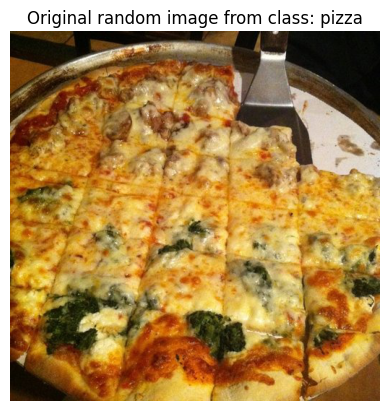

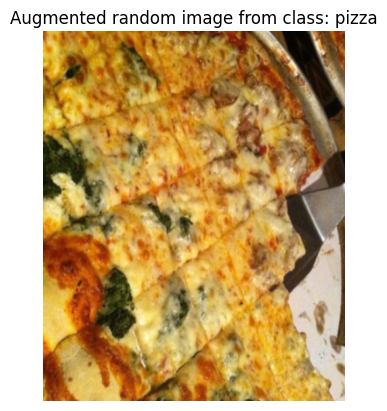

In [39]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation - tf.squeeze() Function: Removes dimensions of size 1 from the shape of a tensor.
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

### Model 1: Feature Extraction Transfer Learning on 1% of the data with data augmentation

In [40]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create Input Layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Data augmentation sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs and don't train it
x = base_model(x, training=False)

# Pool output features using GlobalAveragePooling
x = layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)

# Dense layer as the output layer
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230507-055040
Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.4261 - accuracy: 0.0429 - val_loss: 2.2862 - val_accuracy: 0.1595
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1807 - accuracy: 0.1714 - val_loss: 2.1444 - val_accuracy: 0.2549
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9323 - accuracy: 0.4000 - val_loss: 2.0420 - val_accuracy: 0.3191
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.8175 - accuracy: 0.4286 - val_loss: 1.9191 - val_accuracy: 0.3717
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.5939 - accuracy: 0.6714 - val_loss: 1.8344 - val_accuracy: 0.4161


In [41]:
# Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_aug_layer (Sequential)  (None, None, None, 3)    0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
____________________________________________

The important thing to remember is **data augmentation** **only** runs during **training**. So if we were to evaluate or use our model for inference (predicting the class of an image) the data augmentation layers will be automatically turned off.

In [42]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 87ms/step - loss: 1.8400 - accuracy: 0.4128


[1.839955449104309, 0.41280001401901245]

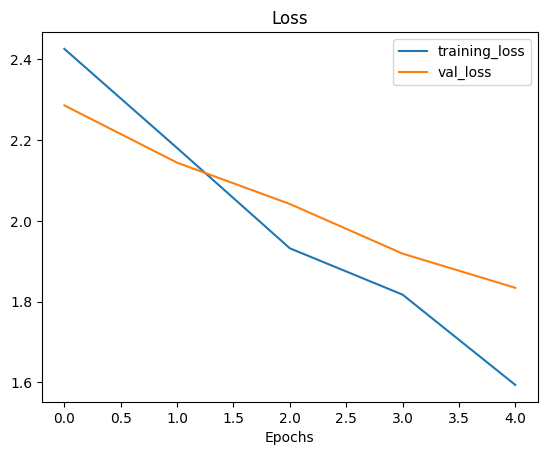

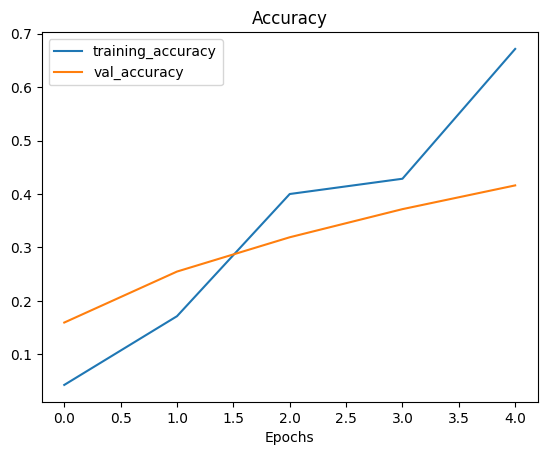

In [43]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

### Model 2: Feature Extraction Transfer Learning with 10% of the data with data augmentation

In [44]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

--2023-05-07 05:51:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   185MB/s    in 0.9s    

2023-05-07 05:51:27 (185 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



Setup Data Inputs

In [45]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Create a functional model with data augmentation

In [46]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

Setup the input shape to our model

In [47]:
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

### Create a Model Checkpoint callback

The ModelCheckpoint callback gives you the ability to save your model, as a whole in the SavedModel format or the weights (patterns) only to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In [48]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         # If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.
                                                         save_best_only=False,   # set to True to save only the best model instead of a model every epoch 
                                                         save_freq='epoch',      # save every epoch
                                                         verbose=1)

Fit the model saving checkpoints every epoch

In [49]:
initial_epochs = 5

history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])  # checkpoint_callback was added to callbacks

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230507-055132
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9596 - accuracy: 0.3787
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 22s 624ms/step - loss: 1.9596 - accuracy: 0.3787 - val_loss: 1.4154 - val_accuracy: 0.6530
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3008 - accuracy: 0.7000
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 503ms/step - loss: 1.3008 - accuracy: 0.7000 - val_loss: 0.9887 - val_accuracy: 0.7632
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9915 - accuracy: 0.7747
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 465ms/step - loss: 0.9915 - accuracy: 0.7747 - val_loss: 0.8111 - val_accuracy: 0.8092
E

In [50]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 67ms/step - loss: 0.6148 - accuracy: 0.8440


[0.6148228645324707, 0.843999981880188]

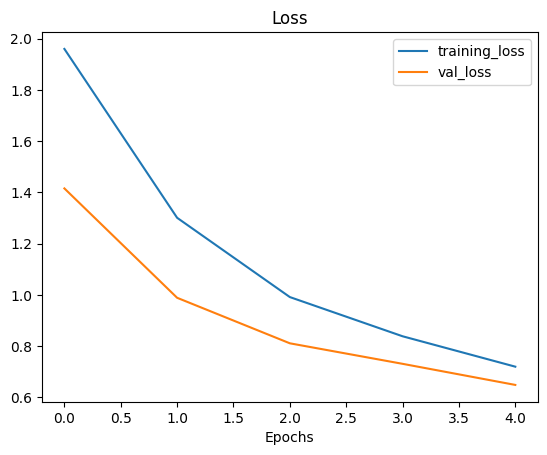

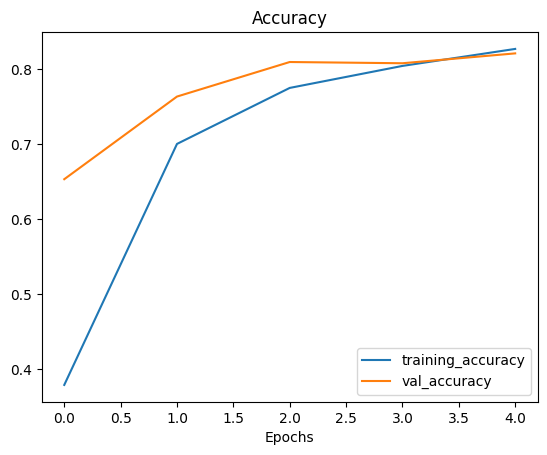

In [51]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

To load saved model weights you can use the the load_weights() method, passing it the path where your saved weights are stored.

In [52]:
model_2.load_weights(checkpoint_path)

loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.6148 - accuracy: 0.8440


These results should very close if not exactly the same. The reason for minor differences comes down to the **precision level** of numbers calculated.

In [53]:
# If the results from our native model and the loaded weights are the same, this should output True
# If the above cell doesn't output True, it's because the numbers are close but not the exact same (due to how computers store numbers with degrees of precision).
results_10_percent_data_aug == loaded_weights_model_results

False

Check to see if loaded model results are very close to native model results (should output True)

In [54]:
import numpy as np

np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [55]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]


### Model 3: Fine-tuning an existing model on 10% of the data

![](https://camo.githubusercontent.com/ee5c623437797bdc2e7c38e4c34be611180530adf18ebf93828f8f5d299aa096/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30352d66696e652d74756e696e672d616e2d656666696369656e746e65742d6d6f64656c2e706e67)

High-level example of fine-tuning an EfficientNet model. Bottom layers (layers closer to the input data) stay frozen where as **top layers** (layers closer to the output data) are **updated** during training.

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation. This means all of the layers in the base model (EfficientNetB0) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

In [56]:
# Layers in loaded model
model_2.layers

In [57]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


In [58]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [59]:
print(len(model_2.layers[2].trainable_variables)) # layer at index 2 is the EfficientNetB0 layer (the base model)
# There is no trainble layer in our base model

0


In [60]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

### Fine-tune the base model to our own data

We are going to unfreeze the top 10 layers and continue training our model (all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.)

Note: Generally, the **less data** you have, the **less layers** you want to **unfreeze** and the more gradually you want to fine-tune.

In [61]:
# Unfreeze entire base model
base_model.trainable = True

# Free again all layers except last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

Recompile the model (always recompile after any adjustments to a model)

In [62]:
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              # learning_rate is 10x lower than before for fine-tuning
              # There's no set standard for setting the learning rate during 
              # fine-tuning, though reductions of 2.6x-10x+ seem to work well in practice.
              metrics=["accuracy"])

Check which layers are tuneable (trainable)

In [63]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [64]:
print(len(model_2.trainable_variables))

12


There's no set standard for setting the learning rate during fine-tuning, though reductions of 2.6x-10x+ seem to work well in practice.

https://arxiv.org/abs/1801.06146


We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

To do this, we can use the initial_epoch parameter of the fit() method. **We'll pass it the last epoch of the previous model's training history** (history_10_percent_data_aug.epoch[-1]).

In [65]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Fit the model again (Same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=fine_tune_epochs,
                                          validation_data=test_data,
                                          initial_epoch=history_10_percent_data_aug.epoch[-1],  # Start from previous last epoch
                                          validation_steps=int(0.25*len(test_data)),
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230507-055309


Epoch 5/10
24/24 [==============================] - 25s 569ms/step - loss: 0.6288 - accuracy: 0.8253 - val_loss: 0.5398 - val_accuracy: 0.8257
Epoch 6/10
24/24 [==============================] - 14s 566ms/step - loss: 0.4869 - accuracy: 0.8507 - val_loss: 0.4966 - val_accuracy: 0.8405
Epoch 7/10
24/24 [==============================] - 10s 402ms/step - loss: 0.4470 - accuracy: 0.8600 - val_loss: 0.4541 - val_accuracy: 0.8520
Epoch 8/10
24/24 [==============================] - 10s 398ms/step - loss: 0.3630 - accuracy: 0.8947 - val_loss: 0.4744 - val_accuracy: 0.8487
Epoch 9/10
24/24 [==============================] - 10s 384ms/step - loss: 0.3385 - accuracy: 0.9013 - val_loss: 0.4537 - val_accuracy: 0.8520
Epoch 10/10
24/24 [==============================] - 9s 366ms/step - loss: 0.3300 - accuracy: 0.8987 - val_loss: 0.4457 - val_accuracy: 0.8618


In [66]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.4272 - accuracy: 0.8588


In [67]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
     

5
11
[0.3786666691303253, 0.699999988079071, 0.7746666669845581, 0.8040000200271606, 0.8266666531562805, 0.8253333568572998, 0.8506666421890259, 0.8600000143051147, 0.8946666717529297, 0.9013333320617676, 0.8986666798591614]


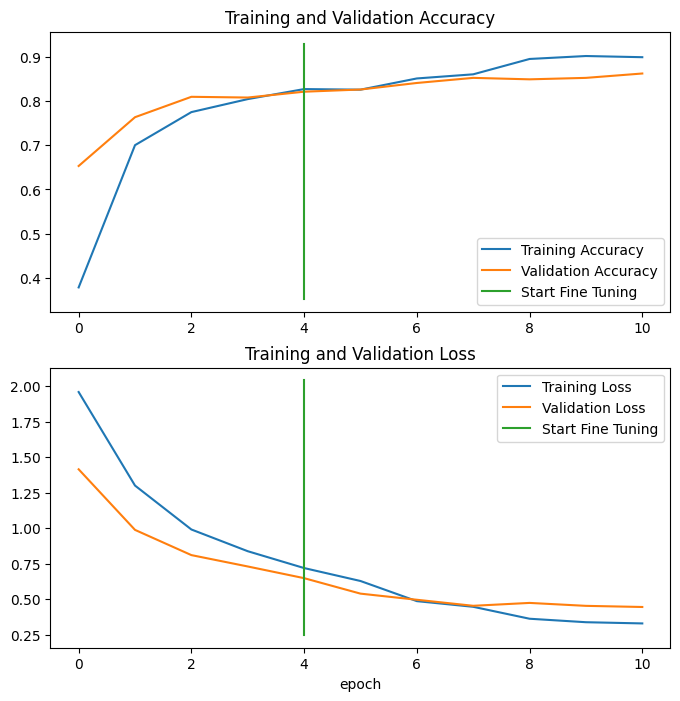

In [68]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

### Model 4: Fine-tuning an existing model all of the data

In the previous model

* Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint.
* Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
* Saved the results and training logs each time.
* Reloaded the model from 1 to do the same steps as 2 but with all of the data.

In [69]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2023-05-07 05:54:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  59.7MB/s    in 7.0s    

2023-05-07 05:54:50 (70.9 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [70]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 

In [71]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


As it is now, our model_2 has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

In [72]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.4272 - accuracy: 0.8588


[0.4271601140499115, 0.8587999939918518]

In [73]:
results_fine_tune_10_percent

[0.4271601438522339, 0.8587999939918518]

Revert the model back to the saved weights.

Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from


In [74]:
model_2.load_weights(checkpoint_path) # revert model back to saved weights

ValueError: ignored

In [75]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 8s 97ms/step - loss: 0.6148 - accuracy: 0.8440


[0.6148227453231812, 0.843999981880188]

In [76]:
# Check to see if the above two results are the same (they should be)
results_10_percent_data_aug

[0.6148228645324707, 0.843999981880188]

Fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [77]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [78]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [79]:
# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

In [80]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230507-055559


Epoch 5/10
235/235 [==============================] - 84s 287ms/step - loss: 0.6512 - accuracy: 0.7915 - val_loss: 0.3529 - val_accuracy: 0.8947
Epoch 6/10
235/235 [==============================] - 58s 243ms/step - loss: 0.5243 - accuracy: 0.8319 - val_loss: 0.3421 - val_accuracy: 0.8865
Epoch 7/10
235/235 [==============================] - 49s 208ms/step - loss: 0.4631 - accuracy: 0.8521 - val_loss: 0.3109 - val_accuracy: 0.8931
Epoch 8/10
235/235 [==============================] - 49s 205ms/step - loss: 0.4145 - accuracy: 0.8665 - val_loss: 0.2797 - val_accuracy: 0.9013
Epoch 9/10
235/235 [==============================] - 46s 194ms/step - loss: 0.3913 - accuracy: 0.8732 - val_loss: 0.3029 - val_accuracy: 0.8997
Epoch 10/10
235/235 [==============================] - 42s 175ms/step - loss: 0.3585 - accuracy: 0.8812 - val_loss: 0.2751 - val_accuracy: 0.9128


In [81]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 66ms/step - loss: 0.2698 - accuracy: 0.9120


[0.2698289752006531, 0.9120000004768372]

5
11
[0.3786666691303253, 0.699999988079071, 0.7746666669845581, 0.8040000200271606, 0.8266666531562805, 0.7914666533470154, 0.8318666815757751, 0.8521333336830139, 0.8665333390235901, 0.873199999332428, 0.8812000155448914]


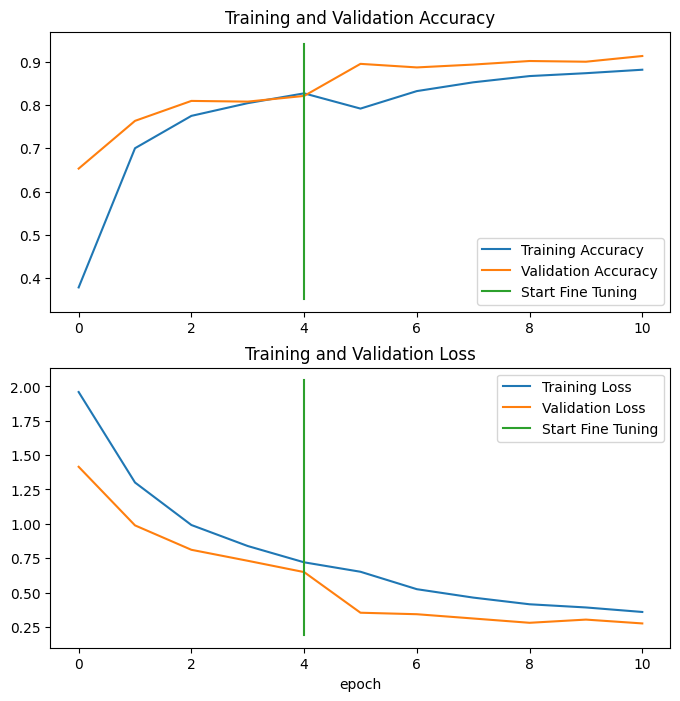

In [82]:

# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

### Viewing our experiment data on TensorBoard

In [83]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished

2023-05-07 06:03:01.007523: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/usr

Once we've uploaded the results to TensorBoard.dev we get a shareable link we can use to view and compare our experiments and share our results with others if needed.

https://tensorboard.dev/experiment/2O76kw3PQbKl0lByfg5B4w/

In [84]:
# View previous experiments
!tensorboard dev list

2023-05-07 06:03:10.588722: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Exception ignored in: <function _xla_gc_callback at 0x7f4d38c129e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 

***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):

In [85]:
# For Remove previous experiments
# !tensorboard dev delete --experiment_id OUbW0O3pRqqQgAphVBxi8Q

### Reference

https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb